# **Analysing Customer Churn**
The goal of this case study is to predict customer churn in a telecom company. By identifying customers who are likely to leave, the company can take proactive measures to retain them. This case study involves data preprocessing, exploratory data analysis (EDA), feature engineering, and model building to achieve high prediction accuracy.

In [2]:
from google.colab import files
uploaded = files.upload()


Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import seaborn as sns

sns.set()
%matplotlib inline

In [7]:
pd.set_option('display.max_columns', None)
#to display all columns of a DataFrame when printing to the console.

## Importing the Data

In [8]:
df= pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [9]:
df.shape

(7043, 21)

In [10]:
# feature exploration

df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [11]:
# Checking missing / NULL values

df.isnull().any()

customerID          False
gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges        False
Churn               False
dtype: bool

In [12]:
# Duplicate value check

df.duplicated().any()

False

In [13]:
# Exploring data types of each feature

df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [15]:
# Rename column names and map values for numeric calculation
def Rename_data(df):
    df.rename(columns={'gender':'Gender'
                       ,'customerID':'CustomerID'
                       ,'Contract':'ContractType'
                       ,'InternetService':'InternetServiceType'
                       ,'tenure':'Tenure'
                      }
              ,inplace=True)


    df['Partner'] = df.Partner.map({'Yes':1,'No':0})
    df['Dependents'] = df.Dependents.map({'Yes':1,'No':0})

    df['PhoneService'] = df.PhoneService.map({'Yes':1,'No':0})
    df['MultipleLines'] = df.MultipleLines.map({'Yes':1,'No':0,'No phone service':0})

    df['InternetService'] = df.InternetServiceType.map({'DSL':1,'Fiber optic':1,'No':0})
    df['OnlineSecurity'] = df.OnlineSecurity.map({'Yes':1,'No':0,'No internet service':0})
    df['OnlineBackup'] = df.OnlineBackup.map({'Yes':1,'No':0,'No internet service':0})
    df['DeviceProtection'] = df.DeviceProtection.map({'Yes':1,'No':0,'No internet service':0})
    df['TechSupport'] = df.TechSupport.map({'Yes':1,'No':0,'No internet service':0})
    df['StreamingTV'] = df.StreamingTV.map({'Yes':1,'No':0,'No internet service':0})
    df['StreamingMovies'] = df.StreamingMovies.map({'Yes':1,'No':0,'No internet service':0})

    df['IsContracted'] = df.ContractType.map({'One year':1,'Two year':1,'Month-to-month':0})
    df['PaperlessBilling'] = df.PaperlessBilling.map({'Yes':1,'No':0})
    df['Churn'] = df.Churn.map({'Yes':1,'No':0})

    df.loc[df['TotalCharges']==' ','TotalCharges'] = np.nan
    df['TotalCharges'] = df['TotalCharges'].astype('float64')
    df.loc[df['TotalCharges']==np.nan,'TotalCharges'] = df['MonthlyCharges'] * df['Tenure']

    return df

In [18]:
from sklearn.utils import shuffle
# clean, shuffle and reindexing traing data set -- shuffling may improve cross validation accuracy
Rename_data = shuffle(Rename_data(df.copy())).reset_index()
Rename_data.head()

,index,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetServiceType,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,ContractType,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetService,IsContracted
0,4723,4274-OWWYO,Male,0,0,0,1,1,0,Fiber optic,0,1,0,0,0,0,Month-to-month,1,Electronic check,74.35,74.35,1,1,0
1,5862,9584-EXCDZ,Female,0,0,0,17,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,0,Bank transfer (automatic),70.50,1165.60,0,1,0
2,6581,2453-SAFNS,Female,1,0,0,54,1,1,DSL,0,1,0,1,1,0,One year,0,Mailed check,72.10,3886.05,0,1,1
3,6379,0940-OUQEC,Male,0,0,0,10,1,1,Fiber optic,0,1,0,0,0,0,Month-to-month,1,Bank transfer (automatic),80.70,788.80,1,1,0
4,3576,2560-QTSBS,Female,0,1,1,72,1,1,No,0,0,0,0,0,0,One year,1,Bank transfer (automatic),23.30,1623.15,0,0,1


In [20]:
# define variables

categorical_vars = ['Gender','InternetServiceType','PaymentMethod','ContractType']
binary_vars = ['SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup'
               ,'DeviceProtection','TechSupport','StreamingTV', 'StreamingMovies','PaperlessBilling','InternetService'
               , 'IsContracted']
numeric_vars = ['Tenure','MonthlyCharges']
target_var = 'Churn'

In [21]:
# encode categorical data to numeric using One-hot encoding method
def one_hot_encoding_features_df(df, cat_feat):
    cat_df = pd.get_dummies(df[cat_feat])
    return cat_df

In [22]:
# merge categorical, numerical, and binary data
def merge_df(categorical=None,binary=None,numerical=None):
    return pd.concat([categorical,binary,numerical],axis = 1)

In [23]:
feature_df = merge_df(one_hot_encoding_features_df(Rename_data,categorical_vars), Rename_data[binary_vars] ,Rename_data[numeric_vars])
target_df = Rename_data[target_var]

In [24]:
def train_test_split_fn(feature, target , test_size=None, random_state=0):
    return train_test_split(feature, target, test_size = test_size,random_state = random_state )

In [25]:
x_train, x_test, y_train , y_test = train_test_split_fn(feature_df,target_df,0.2,42)

In [26]:
RF_model = RandomForestClassifier(oob_score = True, random_state = 42)

In [27]:
RF_model.fit(x_train,y_train)

print("OOB score", RF_model.oob_score_)

OOB score 0.7800851970181044


In [28]:
rf_result = cross_val_score(RF_model, x_train, y_train, scoring = 'accuracy')
print(rf_result.mean())

0.7831043607496284


In [29]:
predicted = np.argmax(RF_model.oob_decision_function_, axis = 1)
metrics.roc_auc_score(y_train, predicted)

0.6817991889300614

In [33]:
# Importing the necessary library
from imblearn.over_sampling import SMOTE

# Applying SMOTE to balance the dataset
smote = SMOTE(random_state=42, sampling_strategy=1.0)
x_train_sm, y_train_sm = smote.fit_resample(x_train, y_train)

In [34]:
RF_model_1 = RandomForestClassifier(oob_score = True, random_state = 42)

In [35]:
RF_model_1.fit(x_train_sm, y_train_sm)

print("OOB score", RF_model_1.oob_score_)

OOB score 0.8520752895752896


In [36]:
rf_result_1 = cross_val_score(RF_model_1, x_train_sm, y_train_sm, scoring = 'accuracy')
print(rf_result_1.mean())

0.8447312385296722


In [37]:
predicted_1 = np.argmax(RF_model_1.oob_decision_function_, axis = 1)
metrics.roc_auc_score(y_train, predicted)

0.6817991889300614

## `Maximum Depth size`

Max depth size 1
Train AUC ROC score  0.752292471042471
Test AUC ROC score  0.7417526961600532
Max depth size 2
Train AUC ROC score  0.7660472972972971
Test AUC ROC score  0.7492225324691959
Max depth size 3
Train AUC ROC score  0.7817326254826256
Test AUC ROC score  0.7633629633424699
Max depth size 4
Train AUC ROC score  0.79488416988417
Test AUC ROC score  0.7676460793606066
Max depth size 5
Train AUC ROC score  0.8098455598455598
Test AUC ROC score  0.7738081819811974
Max depth size 7
Train AUC ROC score  0.841216216216216
Test AUC ROC score  0.7629569382893153
Max depth size 10
Train AUC ROC score  0.8916505791505791
Test AUC ROC score  0.751197581781387
Max depth size 15
Train AUC ROC score  0.963803088803089
Test AUC ROC score  0.7132643389604734
Max depth size 20
Train AUC ROC score  0.9907094594594594
Test AUC ROC score  0.6956912672592669
Max depth size 50
Train AUC ROC score  0.9978281853281853
Test AUC ROC score  0.6987409380843815
Max depth size 100
Train AUC ROC score  0.

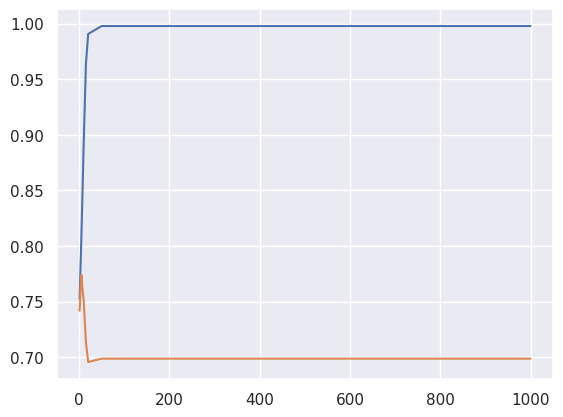

In [78]:
max_depth_size = [1,2,3,4,5,7,10,15,20,50,100,300,500,750,1000]
train_roc_score = []
test_roc_score = []

for depth in max_depth_size:
    model = RandomForestClassifier(oob_score = True, random_state = 42, max_depth = depth)
    model.fit(x_train_sm, y_train_sm)
    train_pred = model.predict(x_train_sm)
    test_pred = model.predict(x_test)
    roc_auc_train = metrics.roc_auc_score(y_train_sm, train_pred)
    roc_auc_test = metrics.roc_auc_score(y_test, test_pred)
    train_roc_score.append(roc_auc_train)
    test_roc_score.append(roc_auc_test)
    print("Max depth size", depth)
    print("Train AUC ROC score ", roc_auc_train)
    print("Test AUC ROC score ", roc_auc_test)


plt.plot(max_depth_size, train_roc_score)
plt.plot(max_depth_size, test_roc_score)

## n_estimator

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


No of trees 1
Train AUC ROC Score 0.78125
Test AUC ROC Score 0.7233278684325128
No of trees 5
Train AUC ROC Score 0.8098455598455598
Test AUC ROC Score 0.7656812767374541
No of trees 10
Train AUC ROC Score 0.8133445945945947
Test AUC ROC Score 0.7813010733406768


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


No of trees 20
Train AUC ROC Score 0.8125
Test AUC ROC Score 0.7729743576606809
No of trees 50
Train AUC ROC Score 0.8086389961389961
Test AUC ROC Score 0.7701987857673489
No of trees 70
Train AUC ROC Score 0.8100868725868726
Test AUC ROC Score 0.7729743576606809
No of trees 100
Train AUC ROC Score 0.8098455598455598
Test AUC ROC Score 0.7738081819811974
No of trees 150
Train AUC ROC Score 0.8097249034749034
Test AUC ROC Score 0.7710326100878654
No of trees 200
Train AUC ROC Score 0.8065878378378378
Test AUC ROC Score 0.7720034838742731
No of trees 500
Train AUC ROC Score 0.8073117760617762
Test AUC ROC Score 0.7749903937290263
No of trees 1000
Train AUC ROC Score 0.807915057915058
Test AUC ROC Score 0.773671132515306


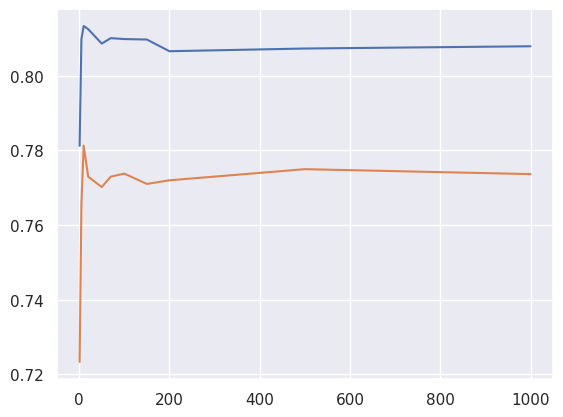

In [100]:
n_estimator_size = [1,5,10,20,50,70,100,150,200,500,1000]
train_roc_score = []
test_roc_score = []


for estimator in n_estimator_size:
    model = RandomForestClassifier(estimator, random_state = 42, oob_score = True, max_depth = 5)
    model.fit(x_train_sm, y_train_sm)
    train_pred = model.predict(x_train_sm)
    test_pred = model.predict(x_test)
    roc_auc_train = metrics.roc_auc_score(y_train_sm, train_pred)
    roc_auc_test = metrics.roc_auc_score(y_test, test_pred)
    train_roc_score.append(roc_auc_train)
    test_roc_score.append(roc_auc_test)
    print("No of trees", estimator)
    print("Train AUC ROC Score", roc_auc_train)
    print("Test AUC ROC Score", roc_auc_test)

plt.plot(n_estimator_size, train_roc_score)
plt.plot(n_estimator_size, test_roc_score)

## Max features

In [101]:
max_features = ['auto', None, 'sqrt','log2',0.7,0.2]
oob_score = []

for feature in max_features:
    model = RandomForestClassifier( n_estimators = 1000, oob_score = True, random_state = 42 ,  max_depth = 5, max_features = feature)
    model.fit(x_train_sm, y_train_sm)
    oob_score.append(model.oob_score_)
    print("Max features", feature)
    print("OOB Score", model.oob_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Max features auto
OOB Score 0.8032094594594594
Max features None
OOB Score 0.8125
Max features sqrt
OOB Score 0.8032094594594594
Max features log2
OOB Score 0.8006756756756757
Max features 0.7
OOB Score 0.8144305019305019
Max features 0.2
OOB Score 0.8032094594594594


## Min Sample Leaf

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


min_sample_leaf 1
OOB Score 0.8032094594594594


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


min_sample_leaf 2
OOB Score 0.8032094594594594


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


min_sample_leaf 3
OOB Score 0.8024855212355212


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


min_sample_leaf 4
OOB Score 0.801761583011583


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


min_sample_leaf 5
OOB Score 0.8018822393822393


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


min_sample_leaf 10
OOB Score 0.8012789575289575


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


min_sample_leaf 15
OOB Score 0.800796332046332


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


min_sample_leaf 20
OOB Score 0.8011583011583011


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


min_sample_leaf 50
OOB Score 0.7981418918918919


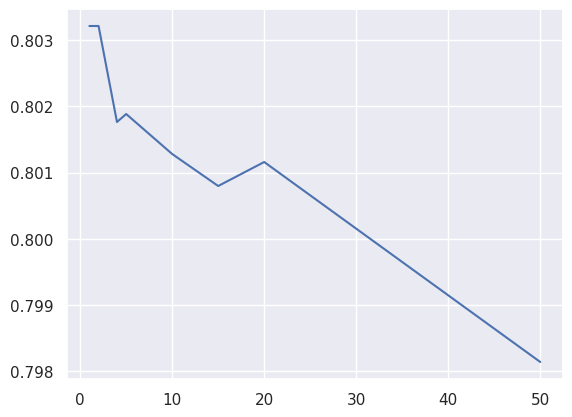

In [102]:
min_sample_leaf = [1,2,3,4,5,10,15,20,50]
oob_score = []

for sample in min_sample_leaf:
    model = RandomForestClassifier(n_estimators = 1000, oob_score = True, random_state = 42, max_depth = 5, min_samples_leaf = sample
                                  , max_features = 'auto')
    model.fit(x_train_sm, y_train_sm)
    oob_score.append(model.oob_score_)
    print("min_sample_leaf", sample)
    print("OOB Score", model.oob_score_)

plt.plot(min_sample_leaf, oob_score)

In [103]:
RF_model_final = RandomForestClassifier(n_estimators = 1000, random_state = 42, max_depth = 5)
RF_model_final.fit(x_train_sm,y_train_sm)

RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=42)

In [104]:
RF_model_final.estimators_

[DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1608637542),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1273642419),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1935803228),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt', random_state=787846414),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt', random_state=996406378),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1201263687),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt', random_state=423734972),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt', random_state=415968276),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt', random_state=670094950),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1914837113),
 DecisionTreeClassifier(max_depth=5, max_feat

In [105]:
# Confusion matrix
predicted = RF_model_final.predict(x_test)
metrics.confusion_matrix(y_test,predicted)

array([[754, 276],
       [ 70, 309]])

In [106]:
# Confusion matrix
metrics.confusion_matrix(y_test,predicted)

array([[754, 276],
       [ 70, 309]])

In [107]:
# Classification report

print(metrics.classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1030
           1       0.53      0.82      0.64       379

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.75      0.77      1409



In [108]:
metrics.roc_auc_score(y_test,predicted)

0.773671132515306

<Axes: >

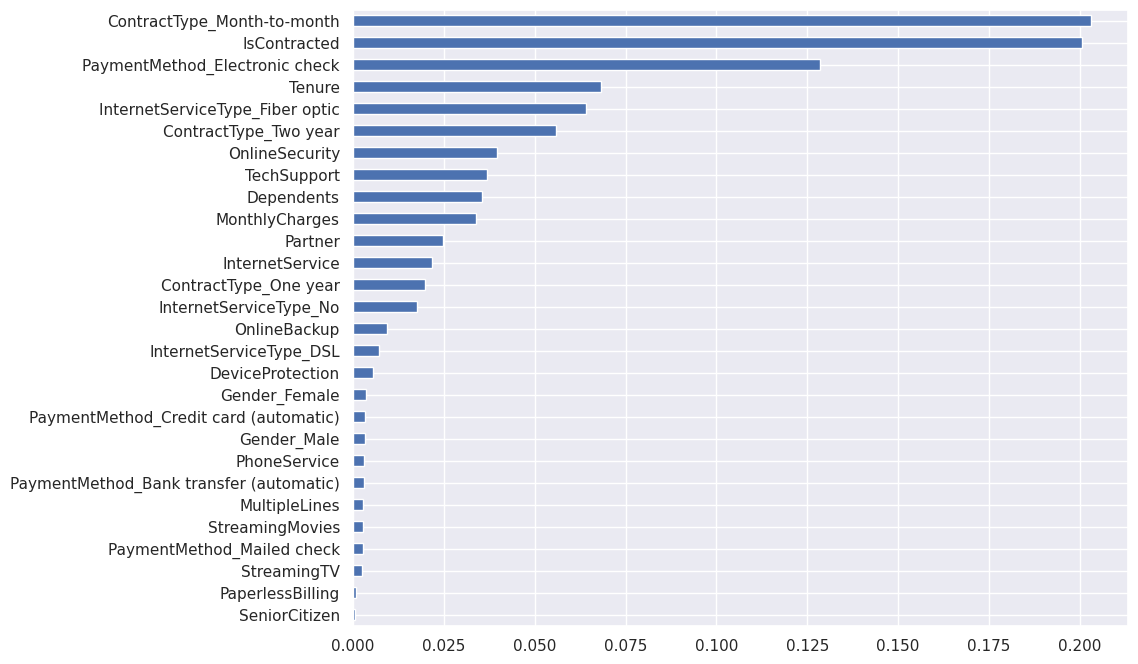

In [109]:
feature_importances = pd.Series(RF_model_final.feature_importances_,index = x_train.columns)
plt.figure(figsize=(10,8))
feature_importances.sort_values().plot(kind='barh')

In [110]:
selected_features = Rename_data[['PaymentMethod','ContractType','InternetServiceType','OnlineSecurity','Tenure','MonthlyCharges','Churn']].copy()
selected_features['Payment_Electronic_Check'] = Rename_data.PaymentMethod.map({'Electronic check':1,'Credit card (automatic)':0
                                                                            ,'Bank transfer (automatic)':0,'Mailed check':0 })
selected_features['Internet_Fiber_Optic'] = Rename_data.InternetServiceType.map({'Fiber optic':1,'DSL':0
                                                                            ,'No':0})
selected_features.head()

,PaymentMethod,ContractType,InternetServiceType,OnlineSecurity,Tenure,MonthlyCharges,Churn,Payment_Electronic_Check,Internet_Fiber_Optic
0,Electronic check,Month-to-month,Fiber optic,0,1,74.35,1,1,1
1,Bank transfer (automatic),Month-to-month,Fiber optic,0,17,70.50,0,0,1
2,Mailed check,One year,DSL,0,54,72.10,0,0,0
3,Bank transfer (automatic),Month-to-month,Fiber optic,0,10,80.70,1,0,1
4,Bank transfer (automatic),One year,No,0,72,23.30,0,0,0


In [111]:
selected_feature_df = merge_df(one_hot_encoding_features_df(selected_features,['ContractType']),selected_features[['Payment_Electronic_Check','Internet_Fiber_Optic','OnlineSecurity']], numerical = selected_features[['Tenure','MonthlyCharges']])
selected_target_df = Rename_data[target_var]

In [112]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Assuming selected_feature_df and selected_target_df are your features and target respectively
feat_x_train, feat_x_test, feat_y_train, feat_y_test = train_test_split_fn(selected_feature_df, selected_target_df, test_size=0.2, random_state=42)
# Assuming selected_feature_df and selected_target_df are already defined

# Split the dataset into training and testing sets
feat_x_train, feat_x_test, feat_y_train, feat_y_test = train_test_split_fn(selected_feature_df, selected_target_df, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42, sampling_strategy='auto')
feat_x_train_sm, feat_y_train_sm = smote.fit_resample(feat_x_train, feat_y_train)

# Now you can proceed with model training, evaluation, etc.


In [113]:

RF_model_final = RandomForestClassifier(n_estimators = 1000, random_state = 42, max_depth = 7,class_weight = 'balanced')
RF_model_final.fit(feat_x_train,feat_y_train)

RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=1000,
                       random_state=42)

In [114]:
predicted = RF_model_final.predict(feat_x_test)

In [115]:
# Confusion matrix
metrics.confusion_matrix(feat_y_test,predicted)

array([[766, 264],
       [ 71, 308]])

In [116]:
# Classification report

print(metrics.classification_report(feat_y_test,predicted))

              precision    recall  f1-score   support

           0       0.92      0.74      0.82      1030
           1       0.54      0.81      0.65       379

    accuracy                           0.76      1409
   macro avg       0.73      0.78      0.73      1409
weighted avg       0.81      0.76      0.77      1409



In [117]:
metrics.roc_auc_score(feat_y_test,predicted)

0.7781771140200322

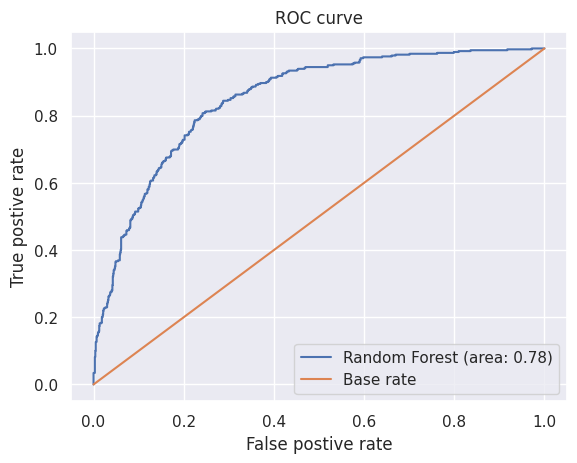

In [118]:
# ROC curve

fpr, tpr, thresold = metrics.roc_curve(feat_y_test, RF_model_final.predict_proba(feat_x_test)[:][:,1])

plt.plot(fpr,tpr , label = 'Random Forest (area: %0.2f)' % metrics.roc_auc_score(feat_y_test,predicted))
plt.plot([0,1],[0,1],label = 'Base rate')
plt.xlabel("False postive rate")
plt.ylabel("True postive rate")
plt.title("ROC curve")
plt.legend()

In [119]:
rf_result_1 = cross_val_score(RF_model_final, feat_x_train, feat_y_train,cv=5, scoring = 'accuracy')
print(rf_result_1.mean())

0.7593237835716571


In [120]:

rf_result_1


array([0.7595386 , 0.76308784, 0.73380657, 0.75066548, 0.78952043])